In [1]:
import torch
import imp
import ppuu.costs
import ppuu.costs.policy_costs_km

imp.reload(ppuu.costs.policy_costs_km)
PolicyCostKMTaper = ppuu.costs.policy_costs_km.PolicyCostKMTaper

from ppuu.data.dataloader import DataStore, Dataset, Normalizer
from ppuu import configs

NPRED = 30
store = DataStore('/home/us441/nvidia-collab/vlad/traffic-data-5/state-action-cost/data_i80_v0/')
ds = Dataset(store, 'train', 20, NPRED, 40, shift=False, random_actions=False)
loader = torch.utils.data.DataLoader(ds, batch_size=2)
normalizer = Normalizer(store.stats)

it = iter(loader)

In [13]:
batch = next(it)

In [14]:
from ppuu.modeling.km import predict_states_seq
from ppuu.costs import PolicyCostKMTaper

config = PolicyCostKMTaper.Config()
config.u_reg = 0
config.rotate = 1
config.curl = 0
config.bug = False
cost = PolicyCostKMTaper(config, None, normalizer)

In [17]:
from ppuu.data.entities import StateSequence

def plot_masks(actions):
    test_actions_target_images = torch.zeros_like(batch.target_state_seq.images)
    test_actions = torch.tensor(actions, dtype=torch.float).unsqueeze(0).unsqueeze(0).expand(2, NPRED, 2)
    # test_pred_states = predict_states_seq(batch['input_states'][:1, -1].cpu(), best_actions.cpu(), km_mpc.normalizer)

    init_state = batch.conditional_state_seq.states[:, -1].cuda()
    init_state[..., :1] = 0 # position
    init_state[..., -1] = 0 # velocity
    init_state[..., -2] = 0 # direction
    init_state[..., -3] = 1 # direction
    init_state = normalizer.normalize_states(init_state)

    zero_actions = normalizer.normalize_actions(torch.zeros_like(test_actions))
    test_zero_states = predict_states_seq(init_state, zero_actions.cuda(), normalizer)
    pred_states = predict_states_seq(init_state, test_actions.cuda(), normalizer)

#   masks = cost.get_masks(images=torch.zeros_like(batch['target_images'].cuda()), 
#                          states=pred_states.cuda(),
#                          actions=test_actions.cuda(),
#                          car_size=batch['car_sizes'].cuda(),
#                          unnormalize=True,
#                          ref_states=test_zero_states.cuda())
    
    context_state_seq = StateSequence(
        images=test_actions_target_images,
        states=test_zero_states,
        car_size=batch.target_state_seq.car_size,
        ego_car_image=batch.target_state_seq.ego_car_image,
    )
    
    masks = cost.get_masks(pred_states.cuda(),
                           test_actions.cuda(),
                           context_state_seq.cuda(),
                           unnormalize=True)
    
    plt.figure(dpi=200)
    plt.suptitle(f'actions=[{test_actions[0, 0, 0].item()}, {test_actions[0, 0, 1].item()}]', fontsize=10, y=0.85)
    for i in range(10):
        plt.subplot(1, 10, i + 1)
        plt.axis('off')
        plt.imshow(masks[0][0, (i+1)*3 - 1].cpu())
    plt.tight_layout()

<Figure size 432x288 with 0 Axes>

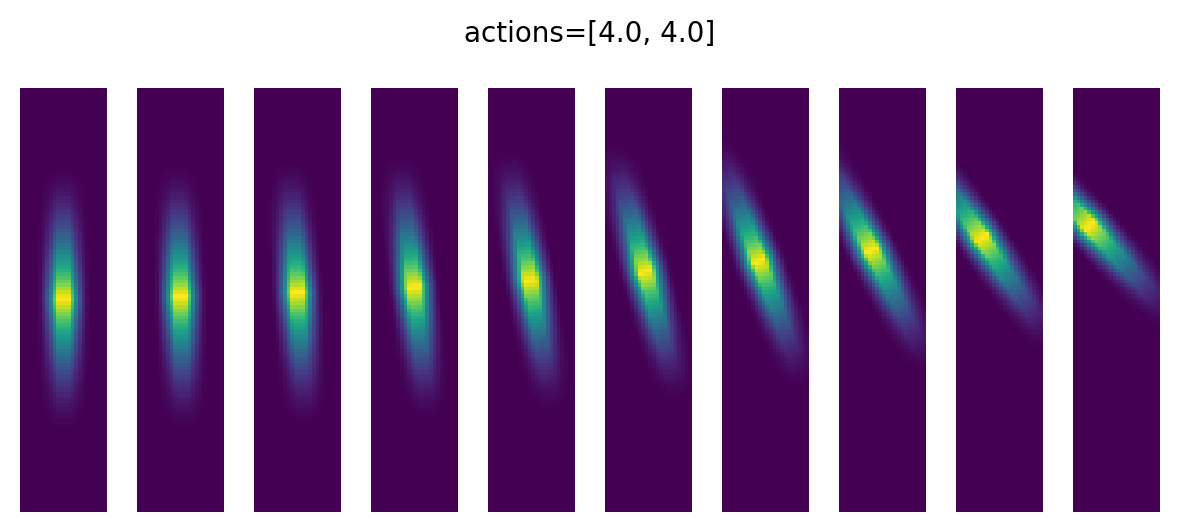

<Figure size 432x288 with 0 Axes>

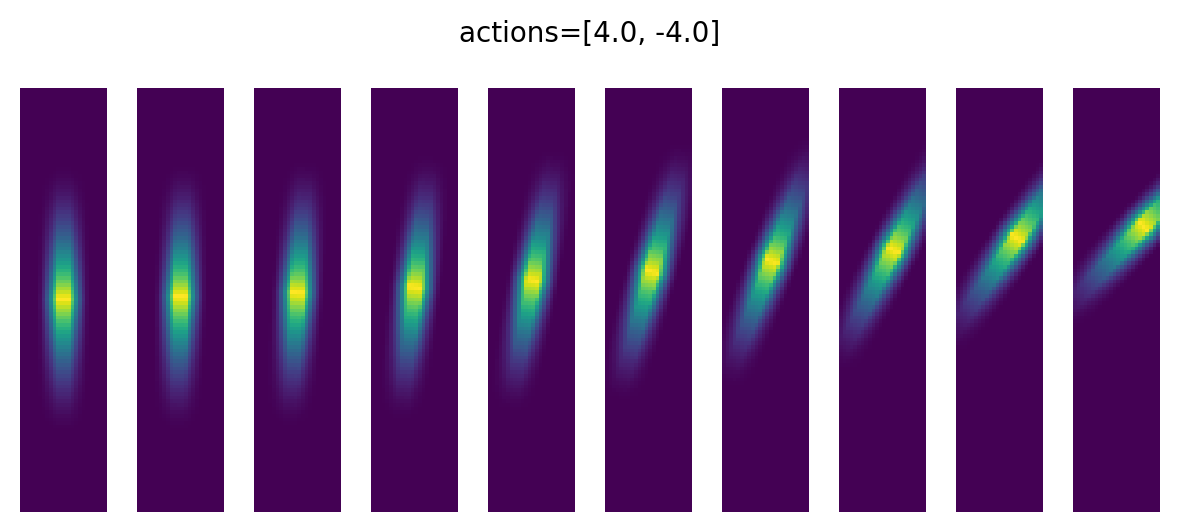

In [19]:
from matplotlib import pyplot as plt
cost.config.bug = False
for acc in [4]:
    for turn in [4, -4]:
        plt.figure()
        plot_masks([acc, turn])

In [12]:
target = batch.target_state_seq
target = normalizer.unnormalize_state_seq(target)
points = cost._get_transformed_points(target.states, target)

tensor(-36.1111) tensor(36.1111)


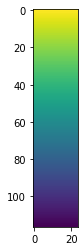

In [18]:
plt.imshow(points[0][0, 0])
print(points[0].min(), points[0].max())

In [8]:
target.states.shape

torch.Size([2, 30, 5])

In [9]:
LOOK_SIDEWAYS_M = 2 * 3.7
LOOK_AHEAD_M = 130 / 3.6

crop_h = 117
crop_w = 24

device = torch.device('cpu')

y = torch.linspace(
            LOOK_SIDEWAYS_M, -LOOK_SIDEWAYS_M, crop_w, device=device
        )
x = torch.linspace(LOOK_AHEAD_M, -LOOK_AHEAD_M, crop_h, device=device)
xx, yy = torch.meshgrid(x, y)


In [10]:
def sample_f(xx, yy):
    return (xx.abs() < 5) * (yy.abs() < 2)

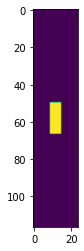

In [11]:
plt.imshow(sample_f(xx, yy))

In [12]:
from ppuu.costs.policy_costs_km import coordinate_shift

nxx, nyy = coordinate_shift(xx, yy, torch.tensor(-10), torch.tensor(-3))

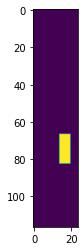

In [13]:
plt.imshow(sample_f(nxx, nyy))